# Implementing polynomial ridge regression

In [421]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Set current working directory
os.chdir('C:/Users/amu_k/subjects-mri-dwi/pre-processing-files/extracted-lab-regions')

# Excel file
excel = pd.ExcelFile('average_values.xlsx')

# Which tensor map-brain region?
df = excel.parse('tf-SP')

# Exclude outliers
outliers = [7, 89, 135, 146, 173]
df = df[~df.index.isin(outliers)]

# Initialise X and y
X = df[['ga']].values
y = df[['average']].values

df.head()

,subject_name,ga,average
0,sub-CC00856XX15_ses-3530,37.43,0.263218
1,sub-CC00861XX12_ses-43210,28.57,0.228846
2,sub-CC00864XX15_ses-2731,36.14,0.257494
3,sub-CC00865XX16_ses-621,31.86,0.239201
4,sub-CC00866XX17_ses-1820,32.14,0.235968


In [422]:
# Define feature and target
X = np.array(df['ga']).reshape(-1,1)
y = np.array(df['average'])

# Create pipeline
model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degree
    'ridge__alpha': [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # L2 penalty (lambda)
}

# Initialise GridSearchCV
#scoring_metric = 'neg_mean_squared_error'
#grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=scoring_metric)

grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Fit the grid search
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
best_degree = best_params['poly__degree']
best_alpha = best_params['ridge__alpha']

# Train the model with the best parameters
#best_model = Pipeline([
    #('poly', PolynomialFeatures(degree=4)),
    #('scaler', StandardScaler()),
    #('ridge', Ridge(alpha=0.01))
#])

# Set model with the best parameters
best_model = grid_search.best_estimator_

#best_model.fit(X, y)

# Evaluate the model
r2_score = best_model.score(X, y)

# Predict target variable
#y_pred = best_model.predict(X)

# Calculate mean squared error
#mse = mean_squared_error(y, y_pred)

# Calculate RMSE
#rmse = np.sqrt(mse)
#print("RMSE: ", rmse)

# Extract the coefficients
coefficients = best_model.named_steps['ridge'].coef_
intercept = best_model.named_steps['ridge'].intercept_

print("Best Polynomial Degree:", best_degree)
print("Best L2 Penalty (alpha):", best_alpha)
print("Ridge Coefficients:", coefficients)
print("Intercept:", intercept)
print("Model R^2 Score:", r2_score)

Best Polynomial Degree: 3
Best L2 Penalty (alpha): 0.1
Ridge Coefficients: [ 0.         -0.03598676  0.00234824  0.04023839]
Intercept: 0.23580259568758874
Model R^2 Score: 0.540328728063443


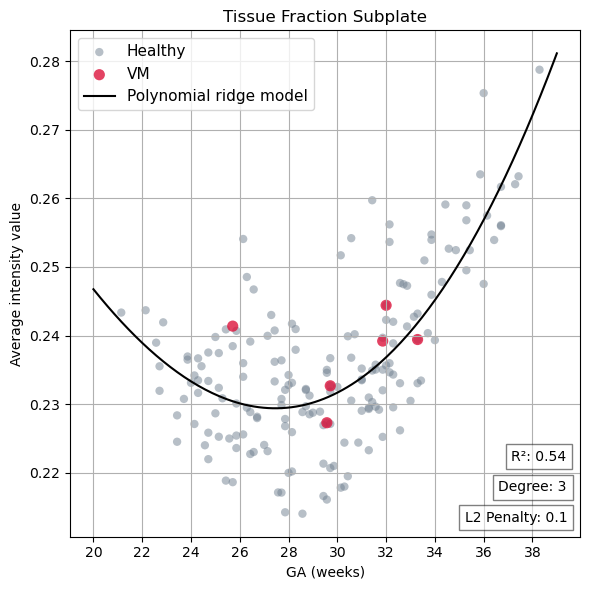

In [442]:
# Predict GA using best model
polyline = np.linspace(20, 39, 200).reshape(-1, 1)
predicted_values = best_model.predict(polyline)

# Plot VM subjects in a different colour
VM_subjects = [3, 8, 53, 54, 137, 166]
normal_subjects = df[~df.index.isin(VM_subjects)]

# Define variable names
#x = 'ga'
#y = 'avg'

# Create empty equation starting with intercept
#equation = f"{y} = {intercept:.5f}"

# Add terms depending on polynomial degree
#if best_degree == 2:
    # For 2nd degree polynomial
    #equation += f"{coefficients[1]:+.5f}*{x}{coefficients[2]:+.5f}*{x}²"
#elif best_degree == 3:
    # For 3rd degree polynomial
    #equation += f"{coefficients[1]:+.5f}*{x}{coefficients[2]:+.5f}*{x}²{coefficients[3]:+.5f}*{x}³"

#print(equation)

plt.figure(figsize=(6, 6))
plt.scatter(normal_subjects['ga'], normal_subjects['average'], label='Healthy', color='slategray', marker='o', alpha=0.5, edgecolors='none')
plt.scatter(df['ga'].iloc[VM_subjects], df['average'].iloc[VM_subjects], label='VM', color='crimson', marker='o', alpha=0.8, s=65, edgecolors= 'none')
plt.plot(polyline, predicted_values, color='black', label='Polynomial ridge model')
plt.text(0.865, 0.15, f"R²: {r2_score:.2f}", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.84, 0.09, f"Degree: {best_degree}", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.774, 0.03, f"L2 Penalty: {best_alpha}", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('GA (weeks)')
plt.ylabel('Average intensity value')
plt.title('Tissue Fraction Subplate')

# Set integer ticks for x-axis
plt.xticks(np.arange(20, 40, 2))

plt.grid(True)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

In [242]:
# Define variable names
x = 'ga'
y = 'avg'

# Create empty equation starting with intercept
equation = f"{y} = {intercept:.5f}"

# Add terms depending on polynomial degree
if best_degree == 2:
    # For 2nd degree polynomial
    equation += f"{coefficients[1]:+.5f}*{x}{coefficients[2]:+.5f}*{x}²"
elif best_degree == 3:
    # For 3rd degree polynomial
    equation += f"{coefficients[1]:+.5f}*{x}{coefficients[2]:+.5f}*{x}²{coefficients[3]:+.5f}*{x}³"

print(equation)

avg = 0.12191-0.00494*ga-0.06108*ga²+0.05097*ga³


In [211]:
# Extract coefficients and intercept from best model
#best_coefficients = best_model.named_steps['ridge'].coef_
#best_intercept = best_model.named_steps['ridge'].intercept_

# Get best polynomial degree
#best_degree = best_params['poly__degree']

# Define variable names
x = 'ga'
y = 'avg'

# Create empty equation starting with intercept
equation = f"{y} = {intercept:.5f}"

# Add terms depending on polynomial degree
for i in range(1, best_degree + 1):
  coefficient = coefficients[i-1]
  if coefficient != 0:  # Only add terms with non-zero coefficients
    if coefficient > 0:
      sign ='+'
    else:
      sign ='-'
    equation += f"{sign}{abs(coefficient):.5f}*{x}^{i}"

# Print equation
print("Equation of the fitted model:")
print(equation)

Equation of the fitted model:
avg = 0.12356-0.37673*ga^2+0.64062*ga^3
